In [ ]:
import numpy
import json
import pandas as pd
import os
import matplotlib.pyplot as plt
from skimage.io import imread
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
map_base_dir = '/content/drive/MyDrive/input/'
map_img_dir = '/content/drive/MyDrive/input/train/images'
json_path = os.path.join(map_base_dir, 'annotation.json')
with open(json_path, 'r') as f:
    annot_data = json.load(f)

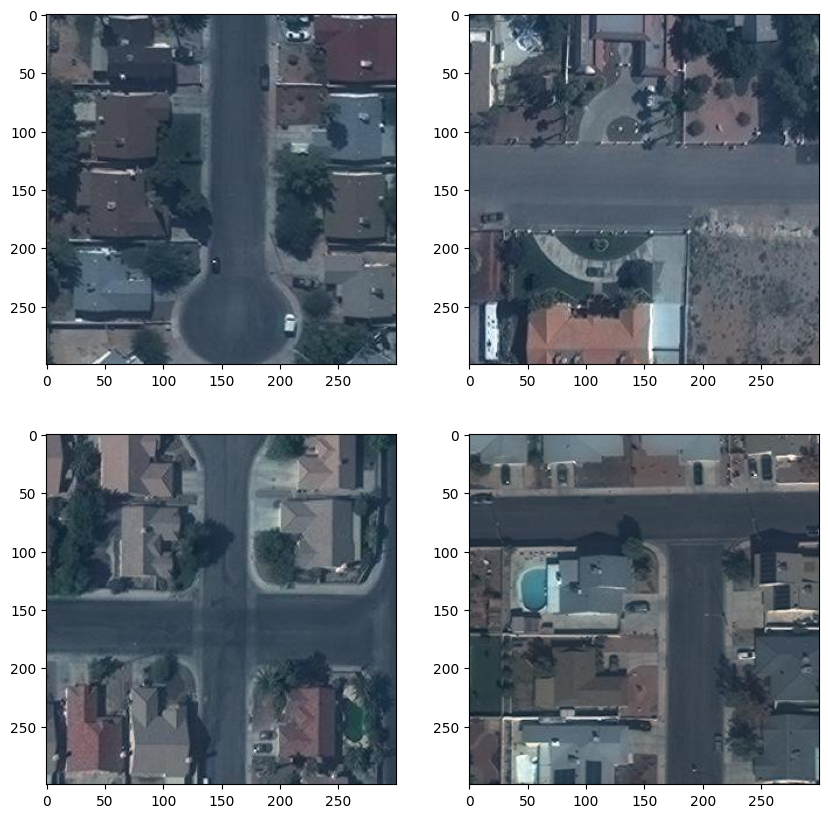

In [ ]:
image_df = pd.DataFrame(annot_data['images'])
image_df.sample(3)
fig, m_axs = plt.subplots(2, 2, figsize = (10, 10))
for c_ax, (_, c_row) in zip(m_axs.flatten(), image_df.sample(4).iterrows()):
    img_data = imread(os.path.join(map_img_dir, c_row['file_name']))
    c_ax.imshow(img_data)

In [ ]:
annot_df = pd.DataFrame(annot_data['annotations'])
annot_df.sample(3)

id  image_id                                       segmentation  \
982055   1942080    227762  [[251.00000000000003, 276.0, 251.0, 253.0, 258...   
726080    618644     72574  [[150.0, 50.0, 85.0, 52.00000000000001, 84.0, ...   
1065924  1024164    120247  [[-6.123233995736766e-16, 145.00000000000003, ...   

           area                                               bbox  \
982055   2511.0                         [217.0, 251.0, 83.0, 49.0]   
726080   2925.0            [17.000000000000004, 84.0, 133.0, 66.0]   
1065924  1792.0  [-6.123233995736766e-16, -6.123233995736766e-1...   

         category_id  iscrowd  
982055           100        0  
726080           100        0  
1065924          100        0

In [ ]:
full_df = pd.merge(annot_df, image_df, how='left', left_on = 'image_id', right_on='id').dropna()
print(image_df.shape[0], '+', annot_df.shape[0], '->', full_df.shape[0])
full_df.sample(2)

280741 + 2395553 -> 2395553


id_x  image_id                                       segmentation  \
1260377   772762     90654     [[300, 49, 274, 54, 263, 15, 300, 7, 300, 49]]   
1907974  1562923    183333  [[75, 70, 75, 76, 52, 76, 52, 70, 43, 70, 43, ...   

           area                bbox  category_id  iscrowd    id_y  \
1260377  1311.0  [49, 263, 251, 37]          100        0   90654   
1907974  3306.0    [43, 19, 33, 56]          100        0  183333   

                file_name  width  height  
1260377  000000090654.jpg    300     300  
1907974  000000183333.jpg    300     300

In [ ]:
def create_boxes(in_rows):
    #TODO: this seems to get a few of the boxes wrong so we stick to segmentation polygons instead
    box_list = []
    for _, in_row in in_rows.iterrows():
        # bbox from the coco standard
        (start_y, start_x, wid_y, wid_x) = in_row['bbox']

        box_list += [Rectangle((start_x, start_y),
                         wid_y , wid_x
                         )]
    return box_list

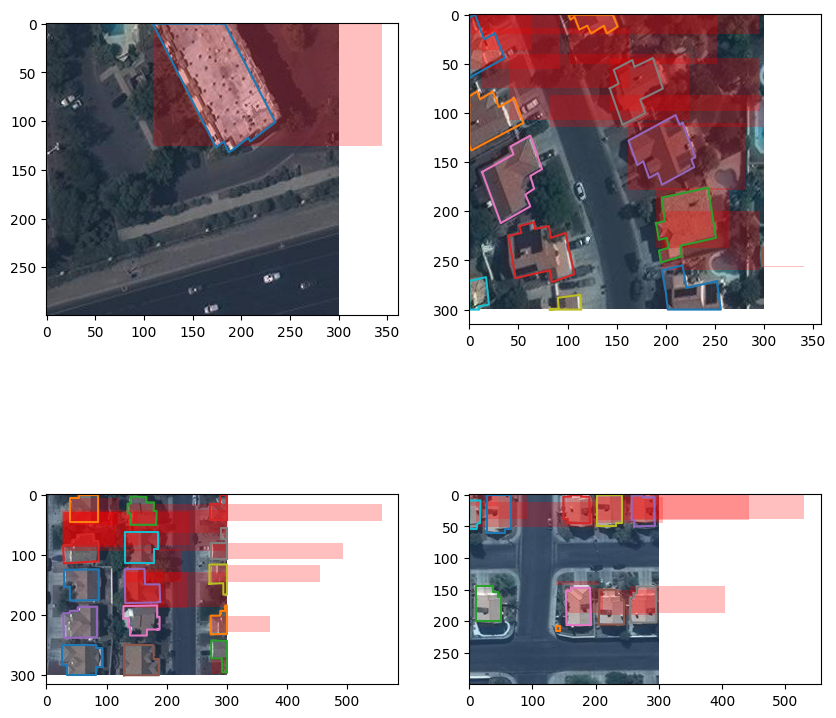

In [ ]:
fig, m_axs = plt.subplots(2, 2, figsize = (10, 10))
for c_ax, (c_id, c_df) in zip(m_axs.flatten(), full_df.groupby('image_id')):
    img_data = imread(os.path.join(map_img_dir, c_df['file_name'].values[0]))
    c_ax.imshow(img_data)
    c_ax.add_collection(PatchCollection(create_boxes(c_df), alpha = 0.25, facecolor = 'red'))
    for _, c_row in c_df.iterrows():
        xy_vec = np.array(c_row['segmentation']).reshape((-1, 2))
        c_ax.plot(xy_vec[:, 0], xy_vec[:, 1], label = c_df['id_x'])

# Convert Polygons to Segmentations
We can use the `Path` function of matplotlib on a `np.meshgrid` of $x,y$ values in order to convert the polygon into a binary image to use as the segmentation.

In [ ]:
from matplotlib.path import Path
from skimage.color import label2rgb
def rows_to_segmentation(in_img, in_df):
    xx, yy = np.meshgrid(range(in_img.shape[0]),
                range(in_img.shape[1]),
               indexing='ij')
    out_img = np.zeros(in_img.shape[:2])
    for _, c_row in in_df.iterrows():
        xy_vec = np.array(c_row['segmentation']).reshape((-1, 2))
        c_ax.plot(xy_vec[:, 0], xy_vec[:, 1], label = c_df['id_x'])
        xy_path = Path(xy_vec)
        out_img += xy_path.contains_points(np.stack([yy.ravel(),
                                                     xx.ravel()], -1)).reshape(out_img.shape)
    return out_img

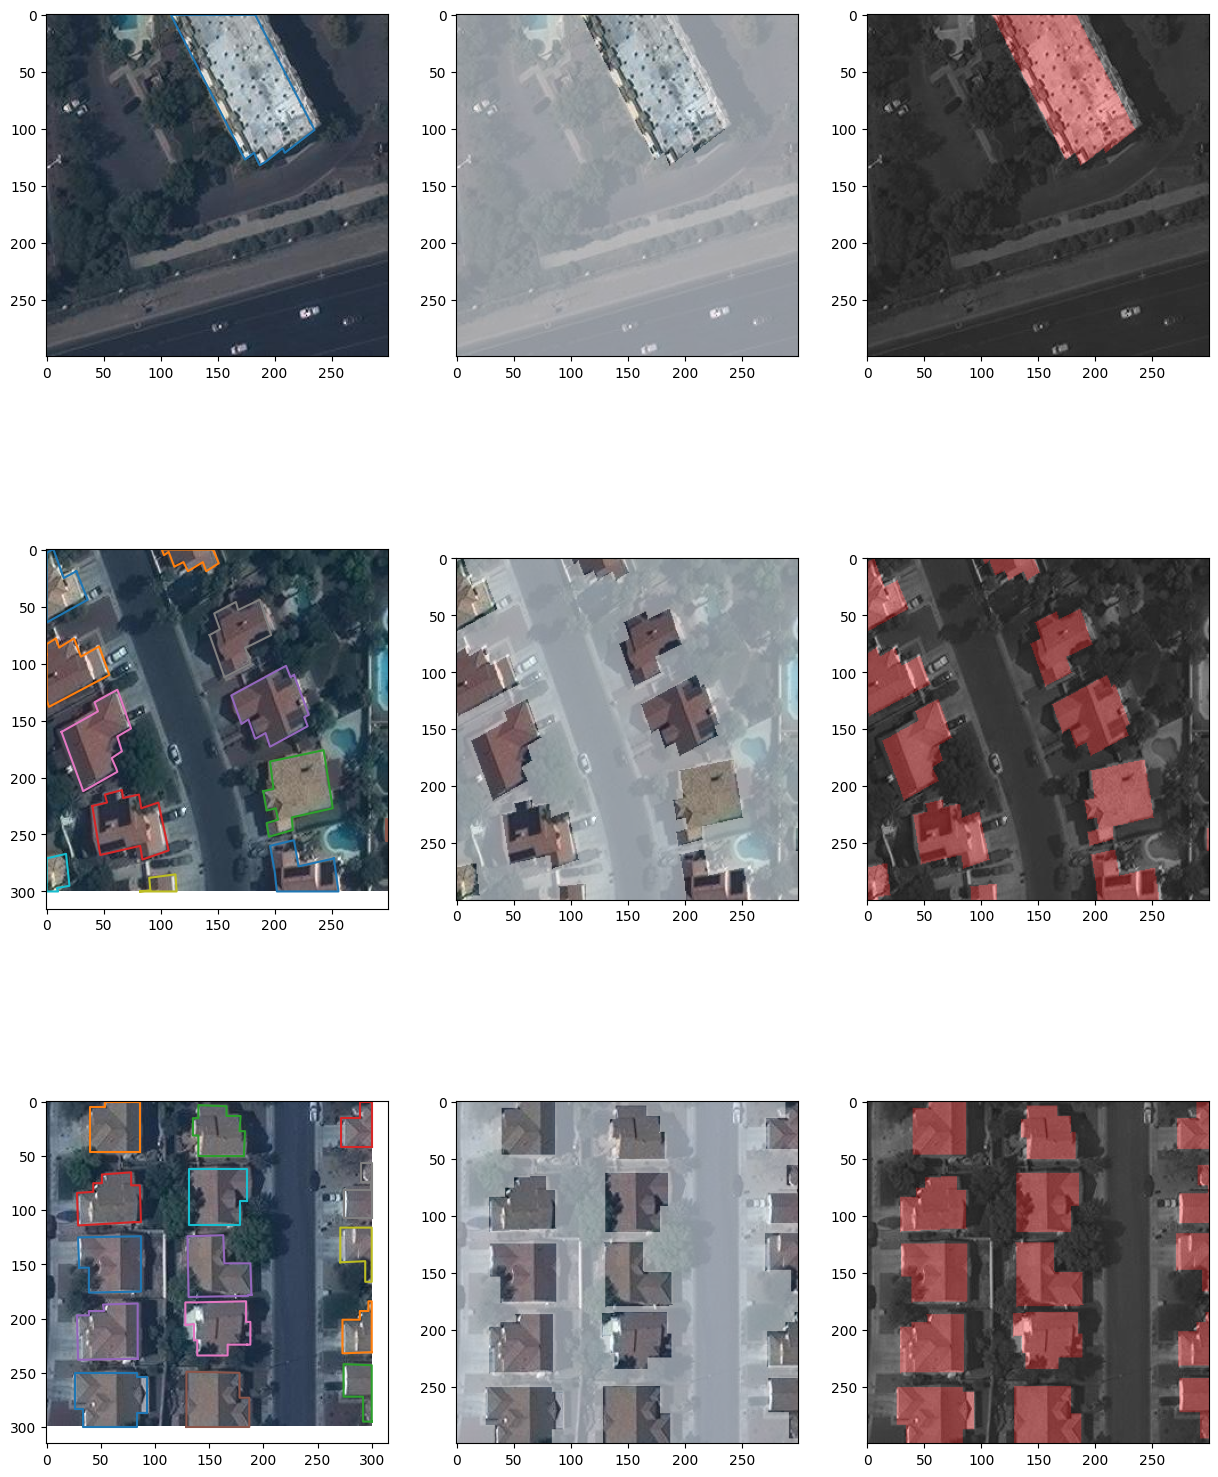

In [ ]:
fig, m_axs = plt.subplots(3, 3, figsize = (15, 20))
for (c_ax, d_ax, f_ax), (c_id, c_df) in zip(m_axs,
                                      full_df.groupby('image_id')):
    img_data = imread(os.path.join(map_img_dir, c_df['file_name'].values[0]))
    c_ax.imshow(img_data)
    out_img = rows_to_segmentation(img_data, c_df)
    rgba_img = np.concatenate([img_data,
                               np.clip(np.expand_dims(127*out_img+127, -1), 0, 255).astype(np.uint8)
                              ], -1)
    d_ax.imshow(rgba_img)

    f_ax.imshow(label2rgb(image=img_data, label=out_img, bg_label = 0))

In [ ]:
from sklearn.model_selection import train_test_split
train_ids, valid_ids = train_test_split(image_df['id'], test_size = 0.25)
train_df = full_df[full_df['image_id'].isin(train_ids)]
valid_df = full_df[full_df['image_id'].isin(valid_ids)]
print(train_df.shape[0], 'training boxes')
print(valid_df.shape[0], 'validation boxes')

1797685 training boxes
597868 validation boxes


In [ ]:
'''def batch_img_gen(in_df, batch_size):
    all_groups = list(in_df.groupby('image_id'))
    out_img, out_seg = [], []
    while True:
        for (_, c_df) in np.random.permutation(all_groups):
            img_data = imread(os.path.join(map_img_dir, c_df['file_name'].values[0]))
            out_img += [img_data]
            out_seg += [np.expand_dims(rows_to_segmentation(img_data, c_df), -1)]
            if len(out_img)>=batch_size:
                yield (np.stack(out_img, 0)/255.0).astype(np.float32), np.stack(out_seg, 0).astype(np.float32)
                out_img, out_seg = [], []
valid_gen = batch_img_gen(valid_df, 8)'''


In [ ]:
!pip install scikit-image
!pip install --upgrade scikit-image


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 29.7 MB/s eta 0:00:00
  Attempting uninstall: scikit-image
    Found existing installation: scikit-image 0.19.3
    Uninstalling scikit-image-0.19.3:
      Successfully uninstalled scikit-image-0.19.3


In [ ]:

from skimage.util import montage



In [ ]:
def batch_img_gen(in_df, batch_size):
    all_groups = list(in_df.groupby('image_id'))
    while True:
        np.random.shuffle(all_groups)  # Shuffle the groups to randomize the order
        out_img, out_seg = [], []
        for (_, c_df) in all_groups:
            img_data = imread(os.path.join(map_img_dir, c_df['file_name'].values[0]))
            out_img.append(img_data)
            out_seg.append(np.expand_dims(rows_to_segmentation(img_data, c_df), -1))
            if len(out_img) >= batch_size:
                yield (np.stack(out_img, 0) / 255.0).astype(np.float32), np.stack(out_seg, 0).astype(np.float32)
                out_img, out_seg = [], []
        # If the loop completes without yielding a batch, shuffle and continue
        if not out_img:
            continue

valid_gen = batch_img_gen(valid_df, 8)

In [ ]:
def create_montage(image_list):
    """
    Create a montage from a list of images.

    Args:
    - image_list: List of images (2D or 3D arrays)

    Returns:
    - montage: Montage image
    """
    num_images = len(image_list)
    rows = int(np.sqrt(num_images))
    cols = int(np.ceil(num_images / rows))

    # Determine dimensions of each image
    height, width, channels = image_list[0].shape

    montage = np.zeros((rows * height, cols * width, channels), dtype=image_list[0].dtype)

    for i, image in enumerate(image_list):
        r = i // cols
        c = i % cols
        montage[r * height:(r + 1) * height, c * width:(c + 1) * width] = image

    return montage


# Define a function to create an RGB montage from a batch of images
def create_rgb_montage(batch_images):
    """
    Create an RGB montage from a batch of images.

    Args:
    - batch_images: Batch of images (4D array with shape (batch_size, height, width, channels))

    Returns:
    - rgb_montage: RGB montage image
    """
    num_channels = batch_images.shape[3]
    single_channel_images = [batch_images[:, :, :, i] for i in range(num_channels)]
    return create_montage(single_channel_images)

# Assuming valid_gen is your generator for generating image batches
t_x, t_y = next(valid_gen)

# Print information about the images and masks
print('x', t_x.shape, t_x.dtype, t_x.min(), t_x.max())
print('y', t_y.shape, t_y.dtype, t_y.min(), t_y.max())



x (8, 300, 300, 3) float32 0.0 1.0
y (8, 300, 300, 1) float32 0.0 1.0


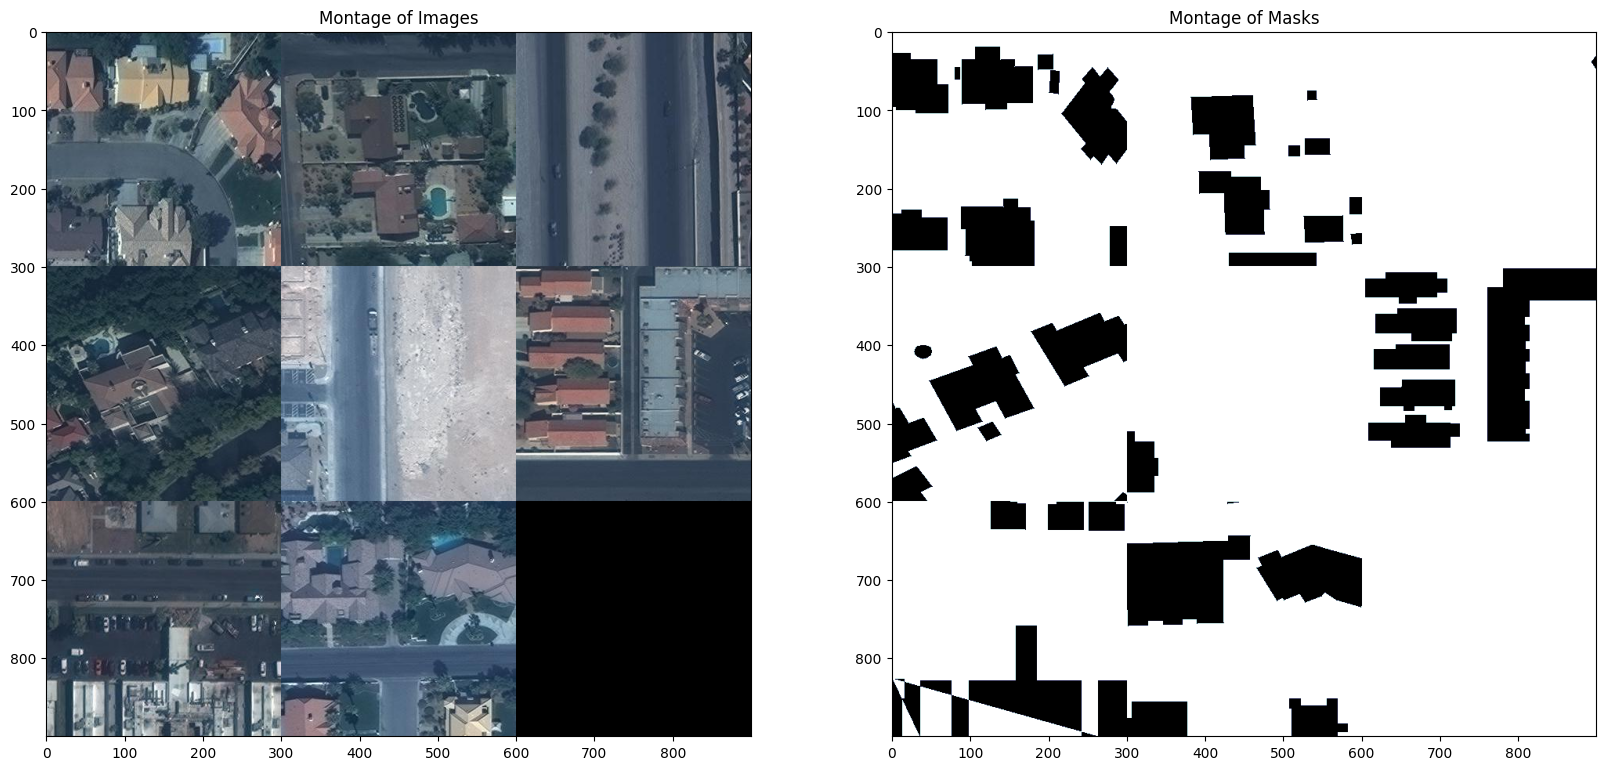

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def create_montage(image_list):
    """
    Create a montage from a list of images.

    Args:
    - image_list: List of images (2D or 3D arrays)

    Returns:
    - montage: Montage image
    """
    num_images = len(image_list)
    rows = int(np.ceil(np.sqrt(num_images)))
    cols = int(np.ceil(num_images / rows))

    # Determine dimensions of each image
    height, width = image_list[0].shape[:2]

    montage = np.zeros((rows * height, cols * width, image_list[0].shape[2]), dtype=image_list[0].dtype)

    for i, image in enumerate(image_list):
        r = i // cols
        c = i % cols
        montage[r * height:(r + 1) * height, c * width:(c + 1) * width] = image

    return montage

# Usage example
t_x_montage = create_montage(t_x)
t_y_montage = create_montage(t_y)

# Display the montages
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(t_x_montage)
ax1.set_title('Montage of Images')
ax2.imshow(t_y_montage[:, :, 0], cmap='bone_r')
ax2.set_title('Montage of Masks')
plt.show()


In [ ]:
'''#from skimage.util import montage
from skimage.util import montage2d

t_x, t_y = next(valid_gen)
print('x', t_x.shape, t_x.dtype, t_x.min(), t_x.max())
print('y', t_y.shape, t_y.dtype, t_y.min(), t_y.max())
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
montage_rgb = lambda x: np.stack([montage2d(x[:, :, :, i]) for i in range(x.shape[3])], -1)
ax1.imshow(montage_rgb(t_x))
ax2.imshow(montage2d(t_y[:, :, :, 0]), cmap = 'bone_r')'''



In [ ]:
!pip install scikit-image


In [ ]:
BLOCK_COUNT = 1
EDGE_CROP = 16
BASE_DEPTH = 16
SPATIAL_DROPOUT = 0.25
GAUSSIAN_NOISE = 0.1
#BATCH_SIZE = 24
#BATCH_SIZE = 32  # Change the batch size to 32
#BATCH_SIZE = 16 # Change the batch size to 16
#BATCH_SIZE = 8 # Change the batch size to 8
BATCH_SIZE = 4 # Change the batch size to 4

In [ ]:
from keras import models, layers
def conv_bn(x, filt, dl_rate=(1,1), preblock = False):
    y = layers.Convolution2D(filt, (3, 3),
                             activation='linear',
                             padding='same',
                             dilation_rate=dl_rate,
                            use_bias=False)(x)
    if preblock: return y
    y = layers.BatchNormalization()(y)
    return layers.Activation('elu')(y)

in_layer = layers.Input(t_x.shape[1:], name = 'RGB_Input')
pp_in_layer = layers.GaussianNoise(GAUSSIAN_NOISE)(in_layer)
pp_in_layer = layers.BatchNormalization()(pp_in_layer)

c = conv_bn(pp_in_layer, BASE_DEPTH//2)
c = conv_bn(c, BASE_DEPTH//2)
c = conv_bn(c, BASE_DEPTH)

skip_layers = [pp_in_layer]
for j in range(BLOCK_COUNT):
    depth_steps = int(np.log2(t_x.shape[1])-2)
    d = layers.concatenate(skip_layers+[conv_bn(c, BASE_DEPTH*2**j, (2**i, 2**i), preblock=True)
                                        for i in range(depth_steps)])
    d = layers.SpatialDropout2D(SPATIAL_DROPOUT)(d)
    d = layers.BatchNormalization()(d)
    d = layers.Activation('elu')(d)
    # bottleneck
    d = conv_bn(d, BASE_DEPTH*2**(j+1))
    skip_layers += [c]
    c = d
d = layers.Convolution2D(1, (1, 1), activation='sigmoid', padding='same')(d)
d = layers.Cropping2D((EDGE_CROP, EDGE_CROP))(d)
d = layers.ZeroPadding2D((EDGE_CROP, EDGE_CROP))(d)
seg_model = models.Model(inputs = [in_layer],
                    outputs = [d])
seg_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 RGB_Input (InputLayer)      [(None, 300, 300, 3)]        0         []                            
                                                                                                  
 gaussian_noise (GaussianNo  (None, 300, 300, 3)          0         ['RGB_Input[0][0]']           
 ise)                                                                                             
                                                                                                  
 batch_normalization (Batch  (None, 300, 300, 3)          12        ['gaussian_noise[0][0]']      
 Normalization)                                                                                   
                                                                                              

In [ ]:
import keras.backend as K
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
import tensorflow as tf
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)
def dice_p_bce(in_gt, in_pred):
    return 0.05*binary_crossentropy(in_gt, in_pred) - dice_coef(in_gt, in_pred)
def true_positive_rate(y_true, y_pred):
    return K.sum(K.flatten(y_true)*K.flatten(K.round(y_pred)))/K.sum(y_true)
seg_model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-4, decay=1e-6), loss=dice_p_bce, metrics=[dice_coef, 'binary_accuracy', true_positive_rate])

In [ ]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
#weight_path="{}_weights.best.hdf5".format('seg_model')
weight_path="/content/drive/MyDrive/output/seg_model_weights.best.hdf5"
checkpoint = ModelCheckpoint(weight_path, monitor='val_dice_coef', verbose=1,
                             save_best_only=True, mode='max', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_dice_coef', factor=0.5,
                                   patience=3,
                                   verbose=1, mode='max', min_delta=0.0001, cooldown=2, min_lr=1e-6)

early = EarlyStopping(monitor="val_dice_coef",
                      mode="max",
                      patience=15) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]

In [ ]:
'''import threading

# Define your batch_img_gen function with a lock
def batch_img_gen_for_loss_history(in_df, batch_size, lock):
    all_groups = list(in_df.groupby('image_id'))
    out_img, out_seg = [], []
    while True:
        for (_, c_df) in np.random.permutation(all_groups):
            img_data = imread(os.path.join(map_img_dir, c_df['file_name'].values[0]))
            out_img += [img_data]
            out_seg += [np.expand_dims(rows_to_segmentation(img_data, c_df), -1)]
            if len(out_img) >= batch_size:
                # Acquire the lock before yielding data
                with lock:
                    yield (np.stack(out_img, 0) / 255.0).astype(np.float32), np.stack(out_seg, 0).astype(np.float32)
                out_img, out_seg = [], []

# Create a lock
lock = threading.Lock()

# Use the generator with the lock
valid_gen = batch_img_gen(valid_df, BATCH_SIZE, lock)'''

In [ ]:
valid_gen = batch_img_gen(valid_df, BATCH_SIZE)
loss_history = [seg_model.fit(batch_img_gen(train_df, BATCH_SIZE),
                              steps_per_epoch=min(train_ids.shape[0]//BATCH_SIZE, 100),
                              epochs=2,
                              validation_data=valid_gen,
                              validation_steps=min(train_ids.shape[0]//BATCH_SIZE, 50),
                              callbacks=callbacks_list,
                              workers=2,
                              use_multiprocessing=True)]


Epoch 1/2
100/100 [==============================] - ETA: 0s - loss: -0.3206 - dice_coef: 0.3978 - binary_accuracy: 0.6531 - true_positive_rate: 0.6243
Epoch 1: val_dice_coef improved from -inf to 0.35561, saving model to /content/drive/MyDrive/output/seg_model_weights.best.hdf5
100/100 [==============================] - 835s 8s/step - loss: -0.3206 - dice_coef: 0.3978 - binary_accuracy: 0.6531 - true_positive_rate: 0.6243 - val_loss: -0.2393 - val_dice_coef: 0.3556 - val_binary_accuracy: 0.4247 - val_true_positive_rate: 0.7922 - lr: 1.0000e-04
Epoch 2/2
100/100 [==============================] - ETA: 0s - loss: -0.4018 - dice_coef: 0.4801 - binary_accuracy: 0.7142 - true_positive_rate: 0.6782
Epoch 2: val_dice_coef improved from 0.35561 to 0.42463, saving model to /content/drive/MyDrive/output/seg_model_weights.best.hdf5
100/100 [==============================] - 866s 9s/step - loss: -0.4018 - dice_coef: 0.4801 - binary_accuracy: 0.7142 - true_positive_rate: 0.6782 - val_loss: -0.3205

In [ ]:
'''valid_gen = batch_img_gen(valid_df, BATCH_SIZE)
loss_history = [seg_model.fit(batch_img_gen(train_df, BATCH_SIZE),
                              steps_per_epoch=min(train_ids.shape[0]//BATCH_SIZE, 100),
                              epochs=2,
                              validation_data=valid_gen,
                              validation_steps=min(train_ids.shape[0]//BATCH_SIZE, 50),
                              callbacks=callbacks_list,
                              workers=2)]'''


In [ ]:
cd /content/drive/MyDrive/output

/content/drive/MyDrive/output


In [ ]:
pwd

'/content/drive/MyDrive/output'

In [ ]:
seg_model.load_weights(weight_path)
#seg_model.save('full_best_model.h5')

seg_model.save('full_best_model.h5')
#seg_model.save('my_model.keras').saving_api.save_model('full_best_model.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
'''t_x, t_y = next(valid_gen)
if t_x.shape[0]>16:
    t_x = t_x[:16]
    t_y = t_y[:16]

print('x', t_x.shape, t_x.dtype, t_x.min(), t_x.max())
print('y', t_y.shape, t_y.dtype, t_y.min(), t_y.max())
pred_y = seg_model.predict(t_x)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (24, 8))
montage_rgb = lambda x: np.stack([montage2d(x[:, :, :, i]) for i in range(x.shape[3])], -1)
ax1.imshow(montage_rgb(t_x))
ax2.imshow(montage2d(t_y[:, :, :, 0]), cmap = 'bone_r')
ax2.set_title('Ground Truth')
ax3.imshow(montage2d(pred_y[:, :, :, 0]), cmap = 'bone_r')
ax3.set_title('Prediction')
fig.savefig('pred_fig.png', dpi=300)'''

In [ ]:
t_x, t_y = next(valid_gen)
if t_x.shape[0] > 16:
    t_x = t_x[:16]
    t_y = t_y[:16]

print('x', t_x.shape, t_x.dtype, t_x.min(), t_x.max())
print('y', t_y.shape, t_y.dtype, t_y.min(), t_y.max())
pred_y = seg_model.predict(t_x)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8))
montage_rgb = lambda x: np.stack([create_montage(x[:, :, :, i]) for i in range(x.shape[3])], -1)
ax1.imshow(montage_rgb(t_x))
ax2.imshow(create_montage(t_y[:, :, :, 0]), cmap='bone_r')
ax2.set_title('Ground Truth')
ax3.imshow(create_montage(pred_y[:, :, :, 0]), cmap='bone_r')
ax3.set_title('Prediction')
#fig.savefig('pred_fig.png', dpi=300)
fig.savefig('/content/drive/MyDrive/output/pred_fig.png', dpi=300)

In [ ]:
#counting code
import cv2
import numpy as np

# Read the masked image
masked_image = cv2.imread("masks.tif")

# Convert the masked image to RGB
masked_image_rgb = cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB)

# Flatten the image to 1D array
pixels = masked_image_rgb.reshape((-1, 3))

# Get unique colors
unique_colors = np.unique(pixels, axis=0)

# Convert masked image to grayscale
gray_masked_image = cv2.cvtColor(masked_image, cv2.COLOR_BGR2GRAY)

# Initialize dictionary to store object counts for each color
color_object_counts = {}

# Loop through each unique color and count objects
for color in unique_colors:
    # Create a mask for the current color
    mask = cv2.inRange(masked_image_rgb, color, color)
    # Find contours in the mask
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # Count the number of contours
    object_count = len(contours)
    # Store the object count for the current color
    color_object_counts[tuple(color)] = object_count

# Print the count of objects for each unique color
print("Object count for each unique color:")
for color, count in color_object_counts.items():
    print(f"Color {color}: {count} objects")


In [ ]:
new_model = tf.keras.models.load_model('full_best_model.keras')

In [ ]:
new_model.